## Package preparation

In [ ]:
#@title Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
import pathlib
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
import re
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import tensorflow_hub as hub
import tensorflow_text as text
from Image_QA.model import QAModel
from transformers import AutoImageProcessor, TFViTModel
import torch
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

## Model Preparation

In [ ]:
#@title Load models

# Load tokenizer
ans_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize=None,
    ngrams = 3,
    output_sequence_length=1
)
ans_tokenizer.set_vocabulary('Image_QA/tokn_vocab')
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=ans_tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=ans_tokenizer.get_vocabulary(),
    invert=True)

# Load Vit
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch32-224-in21k")
vit_model = TFViTModel.from_pretrained("google/vit-base-patch32-224-in21k")
vit_model.trainable = True

# Load BERT
preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", trainable=True, name='BERT_encoder')

# Load QAModel
model = QAModel(vit_model=vit_model, bert_encoder=encoder)
model.load_weights('CADTVL_model_weights/cp-0002.ckpt')

# Video Question answering

In [19]:
#@title Video path for QA
video_path = 'sample_video.mp4'

In [20]:
#@title Take frames from a video
import cv2
import os
import shutil
vidcap = cv2.VideoCapture(video_path)
success,image = vidcap.read()
count = 0
dir = 'frames'
if os.path.exists(dir):
    shutil.rmtree(dir)
os.makedirs(dir)
while success:
  if count%50 == 0:
    cv2.imwrite("frames/%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  count += 1

key_frames = []
frame_list = [f'frames/{f}' for f in os.listdir('frames') if os.path.isfile(os.path.join('frames', f))]
frame_list.sort(key = lambda x:int(x[7:len(x)-4]))

In [21]:
#@title User Questions
# question = ['What color is her dress?',
#             'Where is she sitting on?',
#             'How many people are there?',
#             'What is she facing to?',
#             'Is it a sunny day?',
#             'Is it raining?',
#             'What is above the ocean?',
#             'Are the things that are above the ocean white?',
#             "Are the things that are above the ocean black?",
#             'What color is the ground that she is sitting on']
with open('questions') as file:
    question = [line.rstrip() for line in file]

Answers are based on this frame:


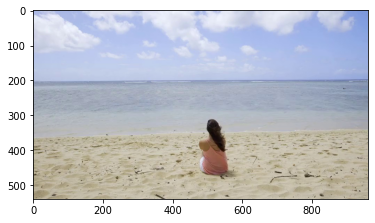

Q: What color is her dress?
Model Answer: pink
 
Q: Where is she sitting on?
Model Answer: beach
 
Q: How many people are there?
Model Answer: 1
 
Q: What is she facing to?
Model Answer: ocean
 
Q: Is it a sunny day?
Model Answer: yes
 
Q: Is it raining?
Model Answer: no
 
Q: What is above the ocean?
Model Answer: cloud
 
Q: Are the things that are above the ocean white?
Model Answer: yes
 
Q: Are the things that are above the ocean black?
Model Answer: no
 
Q: What color is the ground that she is sitting on
Model Answer: brown
 


In [22]:
#@title Model's Answers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
print("Answers are based on this frame:")
img = mpimg.imread(frame_list[0])
imgplot = plt.imshow(img)
plt.show()

lemmatizer = WordNetLemmatizer()
path = frame_list[0]
img = tf.io.read_file(path)
img = tf.io.decode_jpeg(img, channels=3)
img = tf.keras.layers.Resizing(224, 224)(img)
img = img/255
img = tf.transpose(img)
img = tf.expand_dims(img, 0)

with open('answer.txt', 'w') as the_file:
  the_file.write('')
for q in question:
  oq = q
  tokens = word_tokenize(q)
  tokens = [t.lower() for t in tokens if t not in '''!,.;?()-[]{};:'"\<>/@#$+%^&*_~''']
  tokens = [lemmatizer.lemmatize(t) for t in tokens]
  q = " ".join(tokens)
  q = tf.expand_dims(q, 0)
  predictions = model((img, q))
  prediction = tf.argmax(predictions, axis=-1)
  answer = ''
  for w in index_to_word(prediction).numpy()[0]:
    answer =  w.decode("utf-8")
  print("Q: "+oq)
  print("Model Answer: "+ answer)
  print(' ')
  with open('answer.txt', 'a') as the_file:
    the_file.write("Q: "+oq)
    the_file.write("Model Answer: "+ answer)

img = plt.imread(path)
resized_image = tf.image.resize(
  tf.convert_to_tensor([img]), size=(224, 224)
)